# CSC 380 HW\#3 Fall 2025
### Starter Code

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import pandas as pd

print(tf.__version__)

2025-11-04 21:05:53.541167: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762290353.830391      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762290353.919510      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.18.0


## 1. Read in the training and test sets.  Store them in pandas dataframes.

In [2]:
# read in the training set
train_fname = '/kaggle/input/csc-380-hw-3-fall-2025-deep-learning/380hw3_train.csv'
train_df = pd.read_csv(train_fname)
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,4,0,0,0,0,0,0,0,2,3,...,3,0,15,186,147,94,0,0,0,0
1,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,117,83,26,0,0,0,0,0,0,0
3,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# read in the training set
test_fname = '/kaggle/input/csc-380-hw-3-fall-2025-deep-learning/380hw3_test.csv'
test_df = pd.read_csv(test_fname)
test_df.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,2,0,0,...,132,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,20,...,98,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,69,63,0,...,0,0,0,0,0,1,3,0,0,0
3,0,0,0,0,0,0,0,0,32,106,...,92,92,5,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 2. Split the training set into training and validation sets (90% vs. 10%).

In [4]:
# split training set into training (90%) and validation (10%)
import sklearn
from sklearn.model_selection import train_test_split

train, valid = train_test_split(train_df, test_size=0.1, stratify=train_df['label'])

# Ensure values in X_train and Y_train
print (train.shape)
print (valid.shape)

(54000, 785)
(6000, 785)


## 3. Split each of the training and validation sets into X (input features) and Y (target feature).

In [5]:
Y_train = train['label']
X_train = train.drop('label', axis=1)

Y_valid = valid['label']
X_valid = valid.drop('label', axis=1)

print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"X_valid shape: {X_valid.shape}")
print(f"Y_valid shape: {Y_valid.shape}")



X_train shape: (54000, 784)
Y_train shape: (54000,)
X_valid shape: (6000, 784)
Y_valid shape: (6000,)


## 4. Normalize X_train and X_valid -- by dividing all values by 255.0 

In [6]:
X_train = X_train / 255.0
X_valid = X_valid / 255.0

## 5. Normalize the test set (which only contains the X part) in the same way.

In [7]:
X_test = test_df / 255.0

print(f"X_test shape: {X_test.shape}")


X_test shape: (10000, 784)


Better input normalization

In [8]:
# Center and scale by train stats
mean = X_train.mean(axis=0)
std = X_train.std(axis=0) + 1e-6
X_train = (X_train - mean) / std
X_valid = (X_valid - mean) / std
X_test  = (X_test  - mean) / std


## 6. Create a MFFNN model using TensorFlow.

In [9]:
# 6. Create model using GELU activations
FEATURES = 784

model = tf.keras.Sequential([
    tf.keras.Input(shape=(FEATURES,)),
    tf.keras.layers.Dense(1024, activation='gelu',
                          kernel_regularizer=tf.keras.regularizers.l2(2e-4)),
    tf.keras.layers.Dense(512, activation='gelu',
                          kernel_regularizer=tf.keras.regularizers.l2(2e-4)),
    tf.keras.layers.Dense(256, activation='gelu',
                          kernel_regularizer=tf.keras.regularizers.l2(2e-4)),
    tf.keras.layers.Dense(10)  # logits
])


2025-11-04 21:06:20.506609: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


## 7. Compile the model. 

In [10]:
# 7. Compile using SGD optimizer
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)


## 8. Fit the model.

In [11]:
# 8. Fit the model
cbs = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=3,
        min_lr=1e-5, verbose=1),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy', patience=6,
        restore_best_weights=True, verbose=1)
]

history = model.fit(
    X_train, Y_train,
    validation_data=(X_valid, Y_valid),
    epochs=80,
    batch_size=256,
    callbacks=cbs,
    verbose=1
)


Epoch 1/80
211/211 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.7236 - loss: 1.1951 - val_accuracy: 0.8607 - val_loss: 0.7754 - learning_rate: 0.0100
Epoch 2/80
211/211 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.8727 - loss: 0.7250 - val_accuracy: 0.8778 - val_loss: 0.7241 - learning_rate: 0.0100
Epoch 3/80
211/211 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.8908 - loss: 0.6726 - val_accuracy: 0.8808 - val_loss: 0.7078 - learning_rate: 0.0100
Epoch 4/80
211/211 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.9038 - loss: 0.6389 - val_accuracy: 0.8875 - val_loss: 0.6864 - learning_rate: 0.0100
Epoch 5/80
211/211 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.9100 - loss: 0.6091 - val_accuracy: 0.8900 - val_loss: 0.6690 - learning_rate: 0.0100
Epoch 6/80
211/211 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.9201 - loss: 0.5805 - val_accuracy: 0.8890 - val_loss: 0.6710 - learning_rate: 0.0100
Epoch 7/80
211/211 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.9280 - loss: 0.

## 9. Plot the performance that compares training vs. validation sets, on accuracy and loss.

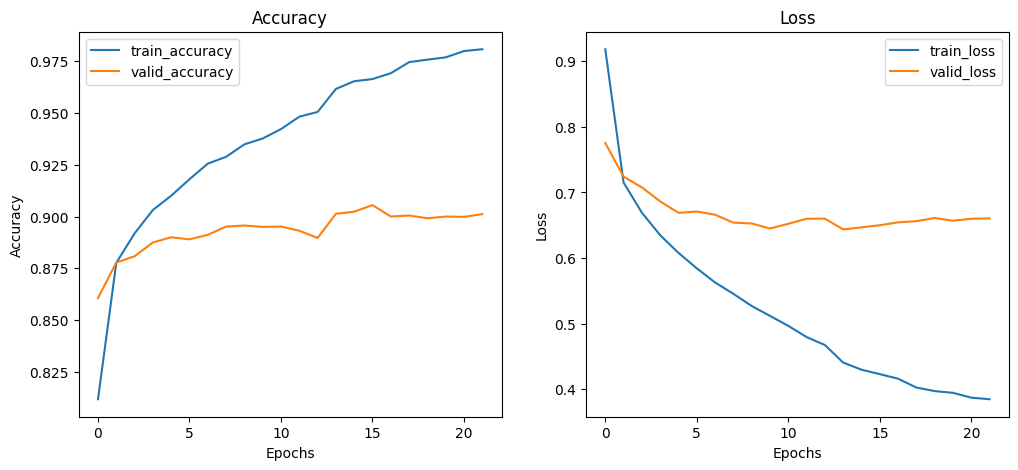

In [12]:
import matplotlib.pyplot as plt
history_df = pd.DataFrame(history.history)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_df['accuracy'], label='train_accuracy')
plt.plot(history_df['val_accuracy'], label='valid_accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_df['loss'], label='train_loss')
plt.plot(history_df['val_loss'], label='valid_loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


## 10. Make predictions for the test set.  
### Note the output must be a probability distribution over the 10 categories

In [13]:
# 10. Make predictions for the test set.
# Convert logits to probabilities
probability_model = tf.keras.Sequential([
    model,
    tf.keras.layers.Softmax()
])

predictions = probability_model.predict(X_test, verbose=1)
print(predictions.shape)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
(10000, 10)


## 11. Write the predictions in a file.

In [14]:
# 11. Write the predictions to a CSV file.
class_names = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'AnkleBoot']

submission_df = pd.DataFrame(predictions, columns=class_names)
submission_df.insert(0, 'ID', range(len(submission_df)))

submission_df.to_csv('submission.csv', index=False)
print("submission.csv created successfully!")
submission_df.head()


submission.csv created successfully!


,ID,T-shirt,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,AnkleBoot
0,0,2.802379e-06,7.294573e-07,8.833478e-04,4.342831e-01,5.592335e-01,9.867885e-08,5.515422e-03,1.084648e-06,7.980987e-05,8.249929e-08
1,1,1.549306e-07,9.999996e-01,1.374405e-07,5.682416e-08,1.206694e-08,7.719573e-09,4.090368e-09,2.975620e-10,8.398575e-09,2.062863e-10
2,2,1.905609e-01,5.500460e-02,4.322299e-02,8.378479e-03,2.450261e-02,3.170978e-04,6.559191e-01,1.433867e-04,2.188163e-02,6.916465e-05
3,3,9.858795e-01,1.548801e-07,1.916512e-04,1.169573e-04,6.031608e-07,6.013495e-08,1.381023e-02,2.394312e-09,8.285832e-07,3.883523e-08
4,4,1.751111e-09,8.865413e-08,2.418723e-08,2.095834e-09,1.213383e-07,1.809980e-07,6.137396e-10,9.999563e-01,6.730466e-07,4.263628e-05
